# Recurrent Neural Network

<img src="https://ibm.box.com/shared/static/v7p90neiaqghmpwawpiecmz9n7080m59.png" alt="Representation of a Recurrent Neural Network" width=80%>

# Long Short-Term Memory
It is an abstraction of how computer memory works. It is "bundled" with whatever processing unit is implemented in the Recurrent Network, although outside of its flow, and is responsible for keeping, reading, and outputting information for the model. The way it works is simple: you have a linear unit, which is the information cell itself, surrounded by three logistic gates responsible for maintaining the data. One gate is for inputting data into the information cell, one is for outputting data from the input cell, and the last one is to keep or forget data depending on the needs of the network.

Thanks to that, it not only solves the problem of keeping states, because the network can choose to forget data whenever information is not needed, it also solves the gradient problems, since the Logistic Gates have a very nice derivative.

### Long Short-Term Memory Architecture

As seen before, the Long Short-Term Memory is composed of a linear unit surrounded by three logistic gates. The name for these gates vary from place to place, but the most usual names for them are:
- the "Input" or "Write" Gate, which handles the writing of data into the information cell, 
- the "Output" or "Read" Gate, which handles the sending of data back onto the Recurrent Network, and 
- the "Keep" or "Forget" Gate, which handles the maintaining and modification of the data stored in the information cell.

<img src=https://ibm.box.com/shared/static/zx10duv5egw0baw6gh2hzsgr8ex45gsg.png width="720"/>
<center>*Diagram of the Long Short-Term Memory Unit*</center>

### Building a LSTM with TensorFlow
LSTM for Classification

Although RNN is mostly used to model sequences and predict sequential data, we can still classify images using a LSTM network. If we consider every image row as a sequence of pixels, we can feed a LSTM network for classification. Lets use the famous MNIST dataset here. Because MNIST image shape is 28*28px, we will then handle 28 sequences of 28 steps for every sample.

In [1]:
# Importing Libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Importing dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting .\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting .\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting .\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting .\t10k-labels-idx1-ubyte.gz


In [4]:
# Defining variables for train & test data
trainings = mnist.train.images
trainlabels = mnist.train.labels
testings = mnist.test.images
testlabels = mnist.test.labels 

ntrain = trainings.shape[0]
ntest = testings.shape[0]
dim = trainings.shape[1]
nclasses = trainlabels.shape[1]
print ("Train Images: ", trainings.shape)
print ("Train Labels  ", trainlabels.shape)
print ("Test Images:  " , testings.shape)
print ("Test Labels:  ", testlabels.shape)

Train Images:  (55000, 784)
Train Labels   (55000, 10)
Test Images:   (10000, 784)
Test Labels:   (10000, 10)


In [11]:
# Defining Network Parameters
sess = tf.InteractiveSession()

n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

learning_rate = 0.001
training_iters = 100000
batch_size = 100
display_step = 10

# The input should be a Tensor of shape: [batch_size, time_steps, input_dimension], but in our case it would be (?, 28, 28)
x = tf.placeholder(dtype="float", shape=[None, n_steps, n_input], name="x") # Current data input shape: (batch_size, n_steps, n_input) [100x28x28]
y = tf.placeholder(dtype="float", shape=[None, n_classes], name="y")

# Randoming initializing weights & biases
weights = { 'out': tf.Variable(tf.random_normal([n_hidden, n_classes])) }
biases = {'out': tf.Variable(tf.random_normal([n_classes])) }

{'out': <tf.Variable 'Variable_8:0' shape=(128, 10) dtype=float32_ref>}


#### Let's Understand the parameters, inputs and outputs

We will treat the MNIST image $\in \mathcal{R}^{28 \times 28}$ as $28$ sequences of a vector $\mathbf{x} \in \mathcal{R}^{28}$. 

#### Our simple RNN consists of  
1. One input layer which converts a $28*28$ dimensional input to an $128$ dimensional hidden layer, 
2. One intermediate recurrent neural network (LSTM) 
3. One output layer which converts an $128$ dimensional output of the LSTM to $10$ dimensional output indicating a class label. 

In [13]:
# Lets design our LSTM Model 

# Lets define a lstm cell with tensorflow
lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

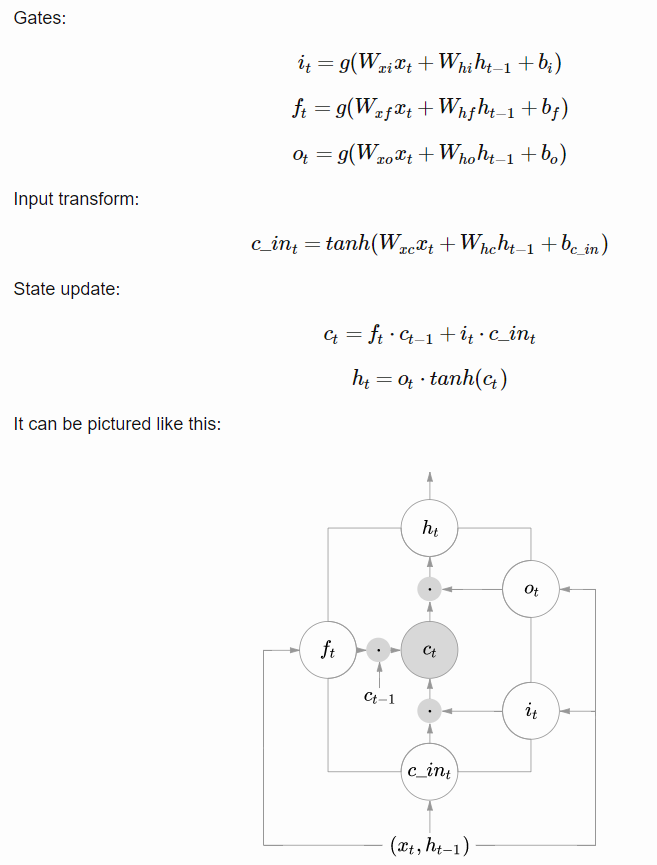

In [23]:
# __dynamic_rnn__ creates a recurrent neural network specified from __lstm_cell__:
outputs, states = tf.nn.dynamic_rnn(lstm_cell, inputs=x, dtype=tf.float32)
print(outputs)

Tensor("rnn_3/transpose:0", shape=(?, 28, 128), dtype=float32)


#### The output of the rnn would be a [100x28x128] matrix. we use the linear activation to map it to a [?x10 matrix]

In [22]:
output = tf.reshape(tf.split(outputs, 28, axis=1, num=None, name='split')[-1],[-1,128])
print(output)
pred = tf.matmul(output, weights['out']) + biases['out']

Tensor("Reshape_1:0", shape=(?, 128), dtype=float32)


In [24]:
# Now, we define the cost function and optimizer:

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [25]:
# Here we define the accuracy and evaluation methods to be used in the learning process:

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [26]:
# Running the tensorflow graph

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:

        # We will read a batch of 100 images [100 x 784] as batch_x
        # batch_y is a matrix of [100x10]
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # We consider each row of the image as one sequence
        # Reshape data to get 28 seq of 28 elements, so that, batxh_x is [100x28x28]
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Iter 1000, Minibatch Loss= 1.933472, Training Accuracy= 0.37000
Iter 2000, Minibatch Loss= 1.606309, Training Accuracy= 0.43000
Iter 3000, Minibatch Loss= 0.963089, Training Accuracy= 0.71000
Iter 4000, Minibatch Loss= 1.097585, Training Accuracy= 0.62000
Iter 5000, Minibatch Loss= 0.703452, Training Accuracy= 0.83000
Iter 6000, Minibatch Loss= 0.712294, Training Accuracy= 0.76000
Iter 7000, Minibatch Loss= 0.670404, Training Accuracy= 0.81000
Iter 8000, Minibatch Loss= 0.693029, Training Accuracy= 0.79000
Iter 9000, Minibatch Loss= 0.555051, Training Accuracy= 0.84000
Iter 10000, Minibatch Loss= 0.482296, Training Accuracy= 0.83000
Iter 11000, Minibatch Loss= 0.350409, Training Accuracy= 0.89000
Iter 12000, Minibatch Loss= 0.500721, Training Accuracy= 0.85000
Iter 13000, Minibatch Loss= 0.434465, Training Accuracy= 0.87000
Iter 14000, Minibatch Loss= 0.472183, Training Accuracy= 0.85000
Iter 15000, Minibatch Loss= 0.361986, Training Accuracy= 0.92000
Iter 16000, Minibatch Loss= 0.3635